## Informações dos Dados

5 Sets de A até E:


*   A: Pacientes saudáveis com olhos abertos
*   B: Pacientes saudáveis com olhos fechados
*   C: Período livre de convulsão fora da zona onset
*   D: Período livre de convulsão dentro da zona onset
*   E: Convulsão

Cada Set contém 100 segmentos de 23.6s cada em 173.61Hz



In [ ]:
#Bibliotecas essenciais
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

#Bibliotecas auxiliares
import os
import random
from tqdm import tqdm

# Ferramentas Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

# PyTorch bibliotecas e módulos
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, RMSprop

path = '/content/drive/MyDrive/EEG_BonnDataset/'

# Pré-processamento dos dados

In [ ]:
Sets_Paths = ['Set_A/', 'Set_B/', 'Set_C/','Set_D/', 'Set_E/',]

def create_set_dataframe(Set_Path, Set_Files_List):
  """Dado o caminho e o arquivo, cria um dataframe a partir dos arquivos .txt"""
  DataFrame = pd.read_csv(Set_Path + Set_Files_List[0], names=Set_Files_List)

  for i in range(1, len(Set_Files_List)):
    with open(Set_Path + Set_Files_List[i]) as file:
      column = []
      for line in file:
        column.append(int(line.rstrip()))

    DataFrame[Set_Files_List[i]] = column

  return DataFrame

In [ ]:
#Criação de cada DataFrame para cada Set
Set_Path = path + Sets_Paths[0]
Set_A_DataFrame = create_set_dataframe(Set_Path, os.listdir(Set_Path))

Set_Path = path + Sets_Paths[1]
Set_B_DataFrame = create_set_dataframe(Set_Path, os.listdir(Set_Path))

Set_Path = path + Sets_Paths[2]
Set_C_DataFrame = create_set_dataframe(Set_Path, os.listdir(Set_Path))

Set_Path = path + Sets_Paths[3]
Set_D_DataFrame = create_set_dataframe(Set_Path, os.listdir(Set_Path))

Set_Path = path + Sets_Paths[4]
Set_E_DataFrame = create_set_dataframe(Set_Path, os.listdir(Set_Path))


In [ ]:
def create_time_seizure_column(frequency, start_time, dataframe, seizure):
  """Criação de uma coluna de tempo e dos labels de Saudável, não saudável, convulsão"""
  time_list = []
  time = frequency**-1

  for i in range(0, 4097):
    rounded_time = round(start_time , 4)
    time_list.append(rounded_time)
    start_time = start_time + time
  
  dataframe['time'] = time_list

  if seizure==0:
    dataframe['seizure'] = 'healthy'
  if seizure==1:
    dataframe['seizure'] = 'unhealthy'
  if seizure==2:
    dataframe['seizure'] = 'seizure'

    

In [ ]:
create_time_seizure_column(173.61, 0.00, Set_A_DataFrame,0)
create_time_seizure_column(173.61, 0.00, Set_B_DataFrame,0)
create_time_seizure_column(173.61, 0.00, Set_C_DataFrame,1)
create_time_seizure_column(173.61, 0.00, Set_D_DataFrame,1)
create_time_seizure_column(173.61, 0.00, Set_E_DataFrame,2)


print(Set_A_DataFrame.loc[[3799]])
Set_A_DataFrame.head()

      Z001.txt  Z002.txt  Z003.txt  ...  Z100.txt     time  seizure
3799        15       -94       -23  ...        -5  21.8824  healthy

[1 rows x 102 columns]


,Z001.txt,Z002.txt,Z003.txt,Z004.txt,Z005.txt,Z006.txt,Z007.txt,Z008.txt,Z009.txt,Z010.txt,Z011.txt,Z012.txt,Z013.txt,Z014.txt,Z015.txt,Z016.txt,Z017.txt,Z018.txt,Z019.txt,Z020.txt,Z021.txt,Z022.txt,Z023.txt,Z024.txt,Z025.txt,Z026.txt,Z027.txt,Z028.txt,Z029.txt,Z030.txt,Z031.txt,Z032.txt,Z033.txt,Z034.txt,Z035.txt,Z036.txt,Z037.txt,Z038.txt,Z039.txt,Z040.txt,...,Z063.txt,Z064.txt,Z065.txt,Z066.txt,Z067.txt,Z068.txt,Z069.txt,Z070.txt,Z071.txt,Z072.txt,Z073.txt,Z074.txt,Z075.txt,Z076.txt,Z077.txt,Z078.txt,Z079.txt,Z080.txt,Z081.txt,Z082.txt,Z083.txt,Z084.txt,Z085.txt,Z086.txt,Z087.txt,Z088.txt,Z089.txt,Z090.txt,Z091.txt,Z092.txt,Z093.txt,Z094.txt,Z095.txt,Z096.txt,Z097.txt,Z098.txt,Z099.txt,Z100.txt,time,seizure
0,12,-56,-37,-31,14,-87,-2,-31,8,-41,14,-64,10,31,30,34,-62,-18,0,-20,-58,6,-40,-1,28,67,19,-4,-42,96,-21,-41,-26,-10,-19,40,-49,-73,18,63,...,-40,-20,-9,-15,-49,20,-25,-13,13,113,-17,-48,24,39,57,-8,69,-34,36,20,-56,-20,-44,-21,-2,-1,16,-30,13,40,-19,-45,6,-133,-3,-51,56,-36,0.0000,healthy
1,22,-50,-22,-43,26,-89,20,-16,17,-38,25,-72,-6,25,19,34,-55,-9,2,-3,-59,-14,-13,-40,30,86,14,4,-49,43,-29,-37,-29,-9,-39,60,-48,-66,34,43,...,-33,-43,15,-23,-59,21,7,-4,21,129,-36,-52,10,41,82,-19,69,-21,27,27,-55,-14,-63,-14,-8,-11,24,-34,30,48,-1,-62,-6,-144,-3,-42,55,-71,0.0058,healthy
2,35,-64,-17,-39,32,-73,42,10,29,-31,31,-52,-14,17,-3,31,-44,9,-1,2,-60,-33,43,-56,8,89,23,10,-37,71,-34,-29,-39,-33,-41,74,-46,-59,45,47,...,-16,-47,35,-25,-56,19,37,2,39,108,-52,-63,-9,43,93,-32,65,-17,24,-5,-53,-12,-85,-12,-27,-11,33,-33,42,35,33,-76,-8,-113,-12,-39,38,-120,0.0115,healthy
3,45,-91,-24,-39,25,-69,48,28,46,-25,36,-24,-14,7,-14,4,-42,33,14,16,-52,-43,69,-10,-9,65,30,15,-12,87,-34,-37,-30,-24,-16,70,-32,-58,37,53,...,15,-37,37,-23,-56,12,40,21,46,60,-66,-55,-18,36,68,-40,59,-27,12,-32,-58,-22,-73,-26,-43,-21,23,5,56,5,51,-98,-6,-74,-24,-47,-5,-150,0.0173,healthy
4,69,-135,-31,-9,16,-51,27,31,50,-32,33,4,-9,4,-12,-15,-33,52,36,29,-47,-40,55,33,-2,19,46,15,0,108,-44,-32,-1,-61,5,67,-34,-53,35,70,...,39,-28,19,-18,-43,13,26,25,48,3,-62,-41,-9,24,23,-55,43,-48,6,-38,-73,-36,-72,-60,-39,-32,9,31,56,-40,49,-108,15,-41,-34,-51,-47,-160,0.0230,healthy


# Visualização dos Dados (Não normalizados)

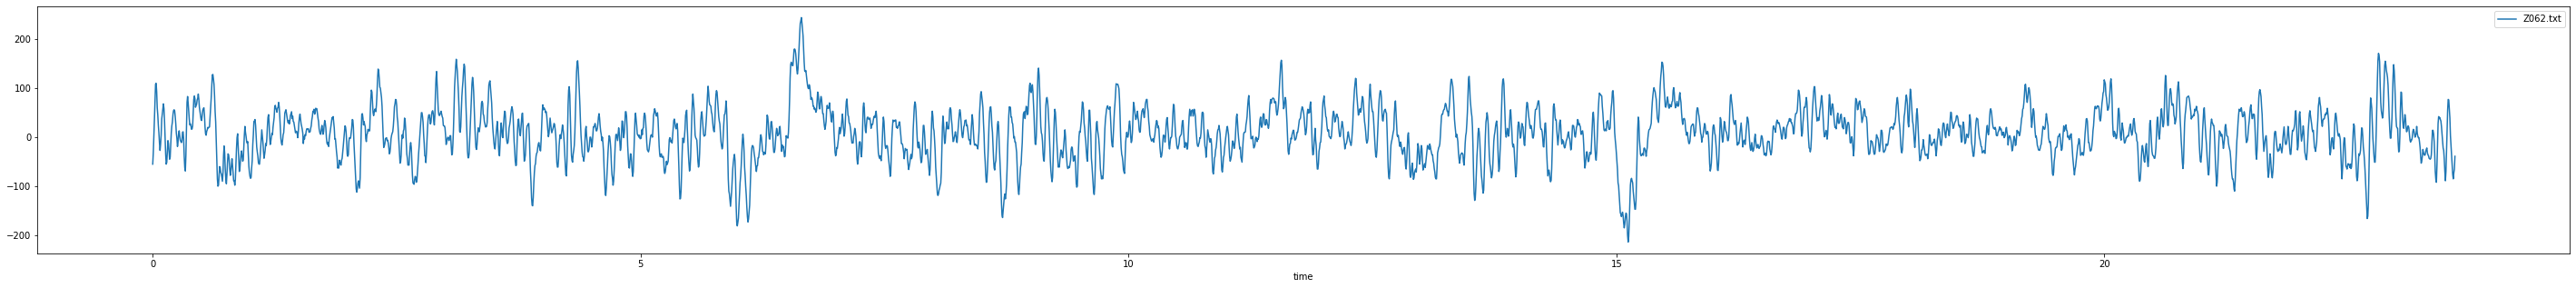

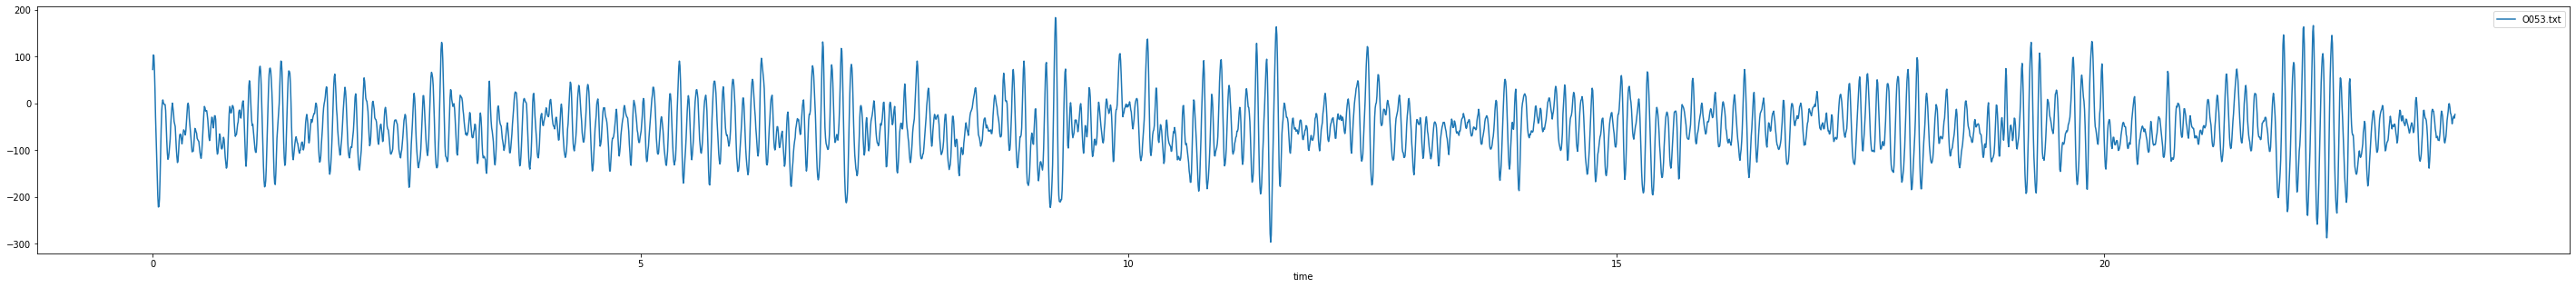

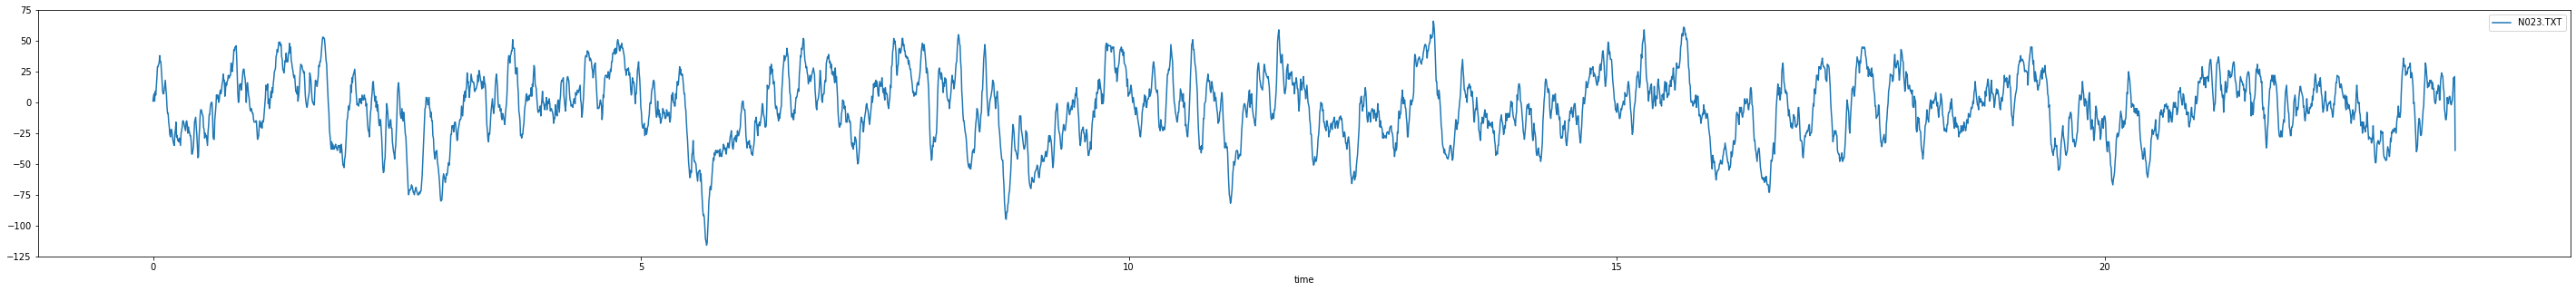

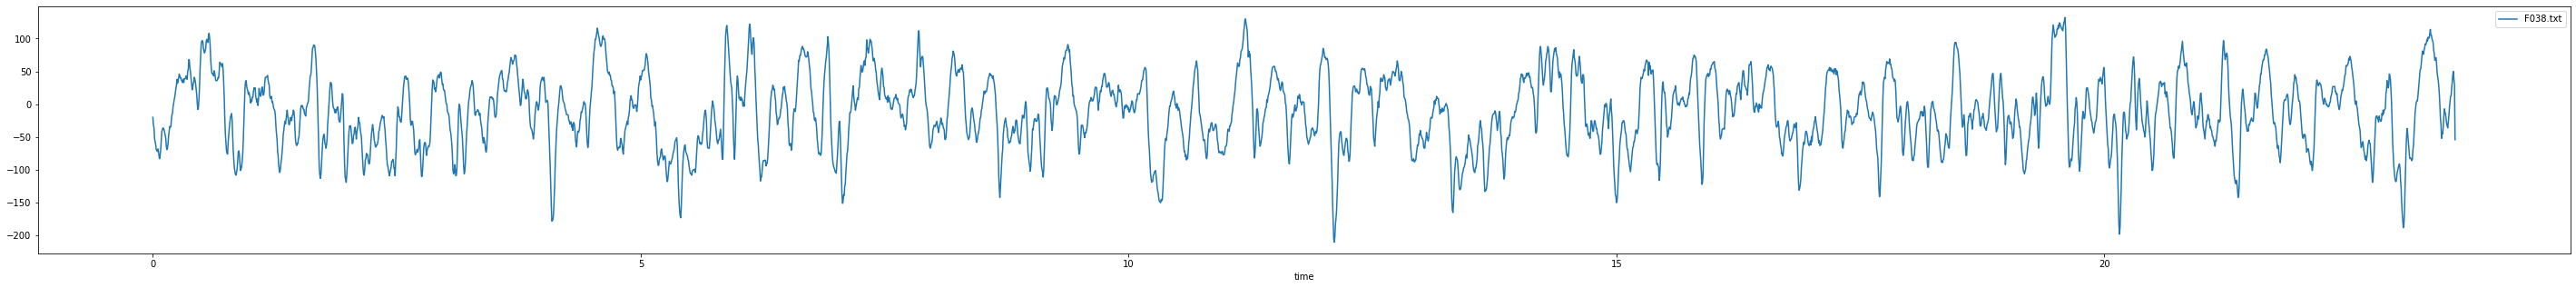

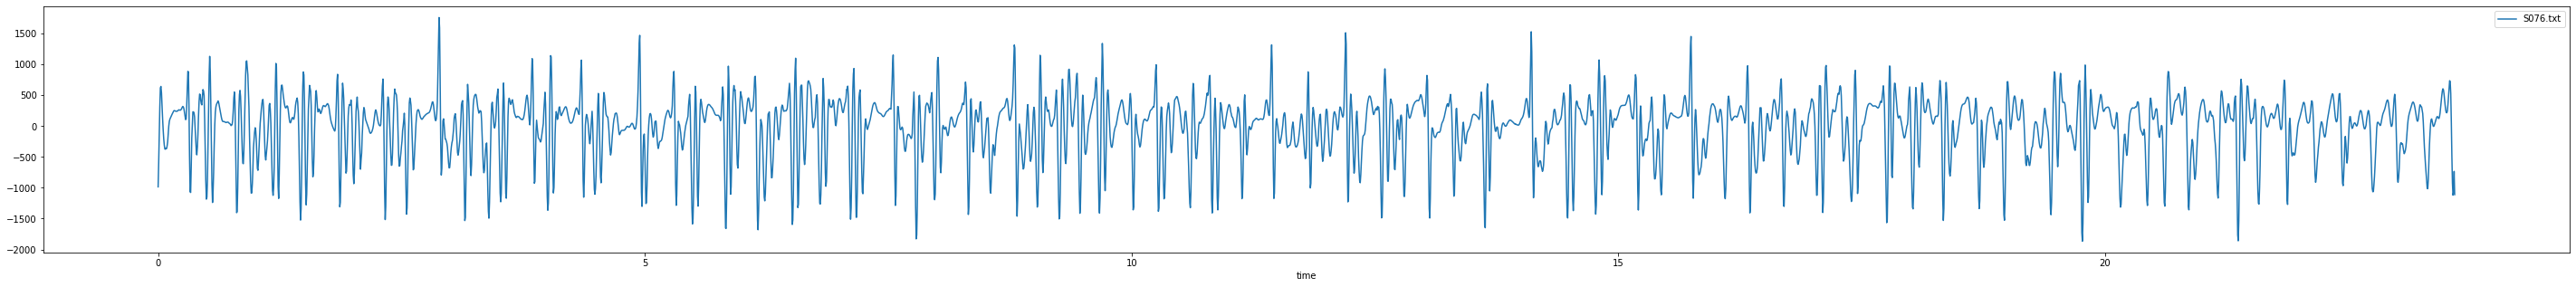

In [ ]:
plt.rcParams['figure.figsize'] = [50, 5]
Set_A_DataFrame.plot(x="time", y=os.listdir(path + Sets_Paths[0]
)[random.randint(0, 99)])
Set_B_DataFrame.plot(x="time", y=os.listdir(path + Sets_Paths[1]
)[random.randint(0, 99)])
Set_C_DataFrame.plot(x="time", y=os.listdir(path + Sets_Paths[2]
)[random.randint(0, 99)])
Set_D_DataFrame.plot(x="time", y=os.listdir(path + Sets_Paths[3]
)[random.randint(0, 99)])
Set_E_DataFrame.plot(x="time", y=os.listdir(path + Sets_Paths[4]
)[random.randint(0, 99)])
plt.show()

#**Criação dos tensors**
Especificações:
500 Sets de 4097 samples cada sendo eles


*   **90% para treino (450)**
*   Dentro dos 90% temos 70% teste e 30% validação 
*   **10% para teste  (50)**




In [ ]:
def create_array(dataframe, label):
  """Transforma o DataFrame em um Numpy Array labelizado"""

  numpy_data = dataframe[dataframe.columns[0:100]].to_numpy()
  numpy_data = numpy_data.transpose()
  
  labels = np.full((100, 1), label)

  return numpy_data, labels

def create_train_test_values(X_Data, X_Labels, data_array, label_array):
  """Divisão entre teste e treino"""

  data_array = np.concatenate([X_Data, data_array])
  label_array = np.concatenate([X_Labels, label_array])

  return data_array, label_array




In [ ]:
A_Data, A_Labels = create_array(Set_A_DataFrame, 0)
B_Data, B_Labels = create_array(Set_B_DataFrame, 0)
C_Data, C_Labels = create_array(Set_C_DataFrame, 1)
D_Data, D_Labels = create_array(Set_D_DataFrame, 1)
E_Data, E_Labels = create_array(Set_E_DataFrame, 2)


data_array, label_array = A_Data, A_Labels
data_array, label_array = create_train_test_values(B_Data, B_Labels, data_array, label_array)
data_array, label_array = create_train_test_values(C_Data, C_Labels, data_array, label_array)
data_array, label_array = create_train_test_values(D_Data, D_Labels, data_array, label_array)
data_array, label_array = create_train_test_values(E_Data, E_Labels, data_array, label_array)


print(data_array)
data_array = np.transpose(data_array)
print(data_array.shape)

[[ 100  124  153 ...   57   95  462]
 [ 340  353  400 ...  512  130  196]
 [-310   93  494 ... -721 -491  910]
 ...
 [ -51  -42  -39 ...   -2    0  -49]
 [  56   55   38 ...  -32   -4   69]
 [ -36  -71 -120 ...    3  -13   30]]
(4097, 500)


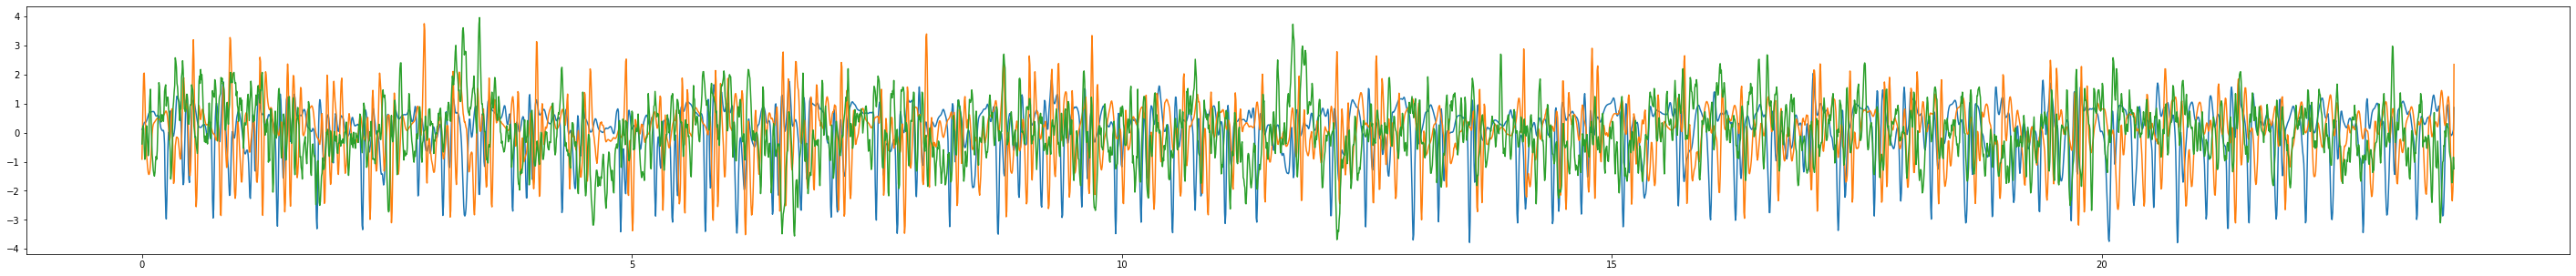

In [ ]:
plt.rcParams['figure.figsize'] = [50, 5]

scaler = StandardScaler().fit(data_array)
data_array = scaler.transform(data_array)
data_array = np.transpose(data_array)


plt.plot(Set_A_DataFrame["time"], data_array[0])
plt.plot(Set_A_DataFrame["time"], data_array[2])
plt.plot(Set_A_DataFrame["time"], data_array[450])

plt.show()

In [ ]:
from torch.utils.data import DataLoader

def train_validation_split(train_x, train_y):
  #Dividir os 90% de testes em 70% teste e 30% validação
  train_x, validation_x, train_y, validation_y = train_test_split(train_x, train_y, test_size = 0.3)

  train_x = torch.as_tensor(train_x, dtype=torch.float32)
  validation_x = torch.as_tensor(validation_x, dtype=torch.float32)

  train_data = []
  for i in range(len(train_x)):
    train_data.append([train_x[i], train_y[i]])

  train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=3, drop_last=True)

  validation_data = []
  for i in range(len(validation_x)):
    validation_data.append([validation_x[i], validation_y[i]])

  validation_loader = torch.utils.data.DataLoader(validation_data, shuffle=True, batch_size=3, drop_last=True)

  return train_loader, validation_loader

In [ ]:
def test_split(test_x, text_y):
  test_x = torch.as_tensor(test_x, dtype=torch.float32)

  test_data = []
  for i in range(len(test_x)):
    test_data.append([test_x[i], test_y[i]])
  
  test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=1, drop_last=True)

  return test_loader

# **Criação da rede neural**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Neural_Net(Module):   
   
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 4, 6, stride=1)
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(4, 4, 5, stride=1)
        self.pool2 = nn.MaxPool1d(2, 2)
        self.conv3 = nn.Conv1d(4, 10, 4, stride=1)
        self.pool3 = nn.MaxPool1d(2, 2)
        self.conv4 = nn.Conv1d(10, 10, 4, stride=1)
        self.pool4 = nn.MaxPool1d(2, 2)
        self.conv5 = nn.Conv1d(10, 15, 4, stride=1)
        self.pool5 = nn.MaxPool1d(2, 2)
        self.linear1 = nn.Linear(125*15, 50)
        self.linear2 = nn.Linear(50, 20)
        self.linear3 = nn.Linear(20, 3)
        self.relu = nn.LeakyReLU()
        self.smax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        #Fase I (Conv+MaxPool)
        s1= self.conv1(x)        #(Batch, 4, 4092)
        s1= self.pool1(s1)       #(Batch, 4, 2046)
        s1= self.relu(s1)    
        #Fase II (Conv+MaxPool)
        s2= self.conv2(s1)       #(Batch, 4, 2042)
        s2= self.pool2(s2)       #(Batch, 4, 1021)
        s2= self.relu(s2)    
        #Fase III (Conv+MaxPool)
        s3= self.conv3(s2)       #(Batch, 10, 1018)
        s3= self.pool3(s3)       #(Batch, 10, 509)
        s3= self.relu(s3)    
        #Fase IV (Conv+MaxPool)
        s4= self.conv4(s3)       #(Batch, 10, 506)
        s4= self.pool4(s4)       #(Batch, 10, 253)
        s4= self.relu(s4)
        #Fase V (Conv+MaxPool)
        s5= self.conv5(s4)       #(Batch, 15, 250)
        s5= self.pool5(s5)       #(Batch, 15, 125)
        s5= self.relu(s5)
        #Fase VI (Fully Connected Layers)
        s6= torch.flatten(s5, 1) #(Batch, 15*125)
        s6= self.linear1(s6)     #(Batch, 50)
        s6= self.relu(s6)
        s6= self.linear2(s6)     #(Batch, 20)
        s6= self.relu(s6)
        s6= self.linear3(s6)     #(Batch, 3)
        s6= self.smax(s6)

        return s6

model = Neural_Net()
print(model)

Neural_Net(
  (conv1): Conv1d(1, 4, kernel_size=(6,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(4, 10, kernel_size=(4,), stride=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(10, 10, kernel_size=(4,), stride=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(10, 15, kernel_size=(4,), stride=(1,))
  (pool5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1875, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=20, bias=True)
  (linear3): Linear(in_features=20, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (smax): Softmax(dim=1)
)


# **Treinamento**

In [ ]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0003)

# Função de treinamento
def train(num_epochs, train_loader, validation_loader, k): 
    best_accuracy = 0.0 
     
    print('Começando treinamento no', k, 'folder.') 
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
 
        # Training Loop 
        for data in train_loader: 
        #for data in enumerate(1, train_loader): 
            inputs, outputs = data  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            optimizer.zero_grad()   # zero the parameter gradients          
            predicted_outputs = model(inputs)   # predict output from the model 
            outputs = outputs.squeeze_()
            train_loss = loss_fn(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer.step()        # adjust parameters based on the calculated gradients 
            running_train_loss +=train_loss.item()  # track the loss value 
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_loader) 
        #train_losses.append(train_loss_value)
 
        # Validation Loop 
        with torch.no_grad(): 
            model.eval() 
            for data in validation_loader: 
               inputs, outputs = data 
               predicted_outputs = model(inputs)
               outputs = outputs.squeeze_()    
               val_loss = loss_fn(predicted_outputs, outputs) 
               # The label with the highest value will be our prediction 
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(validation_loader)
        #validation_losses.append(val_loss_value)
 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
         
        # Print the statistics of the epoch 
        if epoch%10==0:
          print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))

In [ ]:
# Define your execution device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("The model will be running on", device, "device\n") 
model.to(device)    # Convert model parameters and buffers to CPU or Cuda 

# Function to save the model 
def saveModel(): 
    path_model = '/content/drive/MyDrive/EEG_BonnDataset/best_model/NetModel.pth'
    torch.save(model.state_dict(), path_model)

The model will be running on cpu device



In [ ]:
# Plotar o loss do treino e validação 
#plt.rcParams['figure.figsize'] = [10, 5]
#plt.plot(train_losses, label='Training loss')
#plt.plot(validation_losses, label='Validation loss')
#plt.legend()
#plt.show()

In [ ]:
# Function to test the model 


def test():
    y_true = [] 
    y_pred = [] 
    # Load the model that we saved at the end of the training loop 
    path_model = '/content/drive/MyDrive/EEG_BonnDataset/best_model/NetModel.pth'
    model.load_state_dict(torch.load(path_model)) 
     
    running_accuracy = 0 
    total = 0

 
    with torch.no_grad(): 
        for data in test_loader: 
            inputs, outputs = data 
            outputs = outputs.squeeze_()  
            predicted_outputs = model(inputs)
            _, predicted = torch.max(predicted_outputs, 1) 
            y_true.append(outputs.item())
            y_pred.append(predicted.item())
            #total += outputs
            #running_accuracy += (predicted == outputs).sum().item() 

    return y_true, y_pred
        #print(total)
        #print('Accuracy of the model based on the test set of 100 inputs is: %d %%' % (100 * running_accuracy / total))    

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=10)
k = 1;

values_dict = dict.fromkeys({'accuracy','precision','recall','f1-score'}, [])
print(values_dict)

for train_index, test_index in skf.split(data_array, label_array):
    #print("TRAIN:", train_index, "TEST:", test_index) 
    train_x, test_x = data_array[train_index], data_array[test_index] 
    train_y, test_y = label_array[train_index], label_array[test_index]
    
    train_loader, validation_loader = train_validation_split(train_x, train_y)
    test_loader = test_split(test_x, test_y)

    train(50, train_loader, validation_loader, k)
    y_true, y_pred = test() 
    
    accuracy = accuracy_score(y_true, y_pred)
    values_dict['accuracy'].append(accuracy)

    precision = precision_score(y_true, y_pred, average='micro')
    values_dict['precision'].append(precision)

    recall = recall_score(y_true, y_pred, average='micro')
    values_dict['recall'].append(recall)

    f1 = f1_score(y_true, y_pred, average='micro')
    values_dict['f1-score'].append(f1)

    print("Treino do K", k, "finalizado com:")
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("Recall = ", recall)
    print("F1-Score = ", f1)

    
    
    k+=1;

{'accuracy': [], 'recall': [], 'f1-score': [], 'precision': []}
Começando treinamento no 1 folder.
Completed training batch 10 Training Loss is: 0.5705 Validation Loss is: 0.5665 Accuracy is 98 %
Completed training batch 20 Training Loss is: 0.5705 Validation Loss is: 0.5664 Accuracy is 98 %
Completed training batch 30 Training Loss is: 0.5705 Validation Loss is: 0.5664 Accuracy is 98 %
Completed training batch 40 Training Loss is: 0.5705 Validation Loss is: 0.5663 Accuracy is 98 %
Completed training batch 50 Training Loss is: 0.5705 Validation Loss is: 0.5670 Accuracy is 98 %
Treino do K 1 finalizado com:
Accuracy =  0.92
Precision =  0.92
Recall =  0.92
F1-Score =  0.92
Começando treinamento no 2 folder.
Completed training batch 10 Training Loss is: 0.5702 Validation Loss is: 0.5663 Accuracy is 98 %
Completed training batch 20 Training Loss is: 0.5705 Validation Loss is: 0.5663 Accuracy is 98 %
Completed training batch 30 Training Loss is: 0.5705 Validation Loss is: 0.5663 Accuracy i